<a href="https://colab.research.google.com/github/Chaitanya-Chaurasia/Pima-Indians-Diabetes-EDA/blob/main/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Exploratory Data Analysis of Pima Indians Diabetes**


About Dataset - This dataset belongs to the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to predict using various medical factors, whether a person has, or could have diabetes. Few constraints have been placed on this data set. For example- All patients here are female, age >= 21 and belong to the Pima Indian tribe.

Dataset link- https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

Zoom Link: 
https://asu.zoom.us/rec/share/fkvUcPnPGmNCItCuk3ReZmEprFUJUgaLe5PwiA3bVzlZvSESCsgUqTh1PCWYbGRV.GKcXmJZ9gW7iM287?startTime=1678559950000

Passcode: 5^c67e!5

In [ ]:
!pwd

/content


In [ ]:
!ls

diabetes.csv  sample_data


Install the libraries- usually takes around 2-3 minutes.

In [ ]:
!pip install pyspark
!pip install findspark

In [ ]:
import os
import pyspark
import findspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Use `apt` commands to install latest OpenJDK version on your system if not installed. Additionally use `!wget and !tar xf` commands to install pyspark if using local machine. Find the `spark-warehouse` dir on colab/working dir which uses Hive to manage SQL commands.

In [ ]:
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Additionally, to import data hosted online, you can use !curl command.



```
!curl LOCATION > NEW_FILE.csv

```



In [ ]:
findspark.init()

# Optional - to find location of installed files
# findspark.find()

## Checking Pre-reqs


In [ ]:
from pyspark.sql import SparkSession

### Create a SparkSession object. Additionally, you can use the following code using SparkContext and SparkConf: 
```
conf = SparkConf().setAppName('covid19')
sc = SparkContext.getOrCreate(conf = conf)
sc
```

In [ ]:
spark = SparkSession.builder.appName("diabetes").getOrCreate()
display(spark)

## Reading the csv file. Additionally, use pandas.read_csv and sqlContext to convert to sql table to view files.






```
# .read.csv(FILE_NAME, inferSchema = bool, header = bool)
```
inferSchema = True will keep the orignal datatype of the column. When false, each entry is converted ot a String.

header = True will provide the orignal column names and false will give default names c_0 .... c_n.



In [ ]:
df = spark.read.csv('diabetes.csv', header = True, inferSchema = True)

In [ ]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



## Using Pandas

In [ ]:
pdf = pd.read_csv('diabetes.csv')
pdf.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


## Using SQLContext

In [ ]:
from pyspark import SQLContext

In [ ]:
sql = SQLContext(spark)
df_fromSQL = sql.createDataFrame(pdf)
df_fromSQL.show()

## Basic Information of the file

In [ ]:
print(f"There are {df.count()} rows and {len(df.columns)} in the dataset")

There are 768 rows and 9 in the dataset


In [ ]:
df.printSchema()

In [ ]:
df.toPandas().describe().columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## Get count of each data in each column. We use list classification to make it easier

In [ ]:
list = [i for i in pdf.columns]

In [ ]:
for i in list:
  df.groupBy(i).count().show()

## Plotting our first visualisation

### Below, we will be plotting histograms that show the count of each distict element visually

In [ ]:
df.toPandas()['Pregnancies']

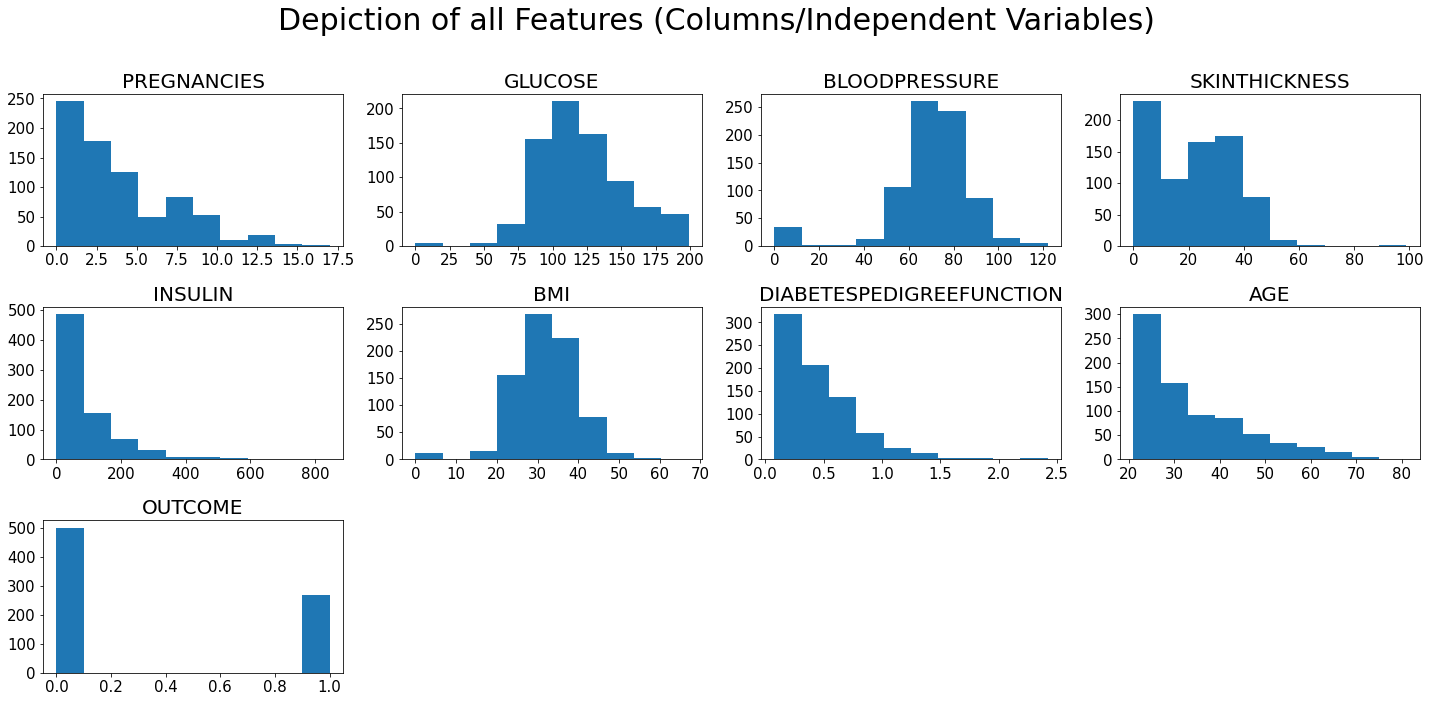

In [ ]:
fig = plt.figure(figsize = (20,10))

title = fig.suptitle("Depiction of all Features (Columns/Independent Variables)", fontsize = 30, verticalalignment = 'center')

for col, num in zip(pdf.columns, range(1,len(pdf.columns) + 1)):
  
  ax = fig.add_subplot(3, 4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(fontsize = 15)
  plt.yticks(fontsize = 15)
  plt.title(col.upper(), fontsize = 20)

plt.tight_layout()
title.set_y(0.95)
fig.subplots_adjust(top = 0.85, hspace = 0.4)
plt.show()

### Checking for missing data. If found, use *sklearn.impute.SimpleImputer* to fix it by removing or strategizing it.

In [ ]:
from pyspark.sql.functions import *

df.select([count(when(isnan(i), i)).alias(i) for i in df.columns]).toPandas()

# use .alias(i) for aesthetic purposes. Not mandatory.

# User Defined Function (UDF)

### PySpark allows us to define user-defined functions to automate displaying and modification of data through the UDF class

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

### In our table, we will make a column 'HasDiabetes'that will output yes or no instead of a binary output. We need to convert this to a String result Y/N which we can do through StringType() class. We will also drop the Outcome column
```
# udf(lambda: , DATA_TYPE)
```

In [ ]:
lastCol = udf(lambda x: "Y" if x == 1 else "N", StringType())

In [ ]:
df = df.withColumn("HasDiabetes", lastCol('Outcome')).drop("Outcome")

In [ ]:
df.show(10)

In [ ]:
df

DataFrame[Pregnancies: int, Glucose: int, BloodPressure: int, SkinThickness: int, Insulin: int, BMI: double, DiabetesPedigreeFunction: double, Age: int, HasDiabetes: string]

###Now, lets try to categorize age instead of using numbers by adding a new column using *udf* method

In [ ]:
def age_categorize(age):
  if (age <= 25):
    return "Under 25"
  elif (age >= 25 and age <= 35):
    return "Between 25 and 35"
  elif (age > 35 and age < 50):
    return "Between 36 and 50"
  elif (age >= 50):
    return "Over 50"
  else :
    return "NA"

In [ ]:
ageCol = udf(age_categorize)
df = df.withColumn('Categorized Age', ageCol('Age')).drop('Age')

In [ ]:
df.show(10)

+-----------+-------+-------------+-------------+-------+----+------------------------+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|HasDiabetes|  Categorized Age|
+-----------+-------+-------------+-------------+-------+----+------------------------+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627|          Y|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351|          N|Between 25 and 35|
|          8|    183|           64|            0|      0|23.3|                   0.672|          Y|Between 25 and 35|
|          1|     89|           66|           23|     94|28.1|                   0.167|          N|         Under 25|
|          0|    137|           40|           35|    168|43.1|                   2.288|          Y|Between 25 and 35|
|          5|    116|           74|            0|      0

## Creating a User-defined method that displays stats like AVG, MAX, MIN and COUNT of a specific features WHERE GROUPBY(age)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.functions import *

In [ ]:
def groupBy_age_onAnyFeature(window, feature):

  return df.select(['Categorized Age', feature]).groupBy('Categorized Age').agg(
      F.count(feature).alias('UserCount'),
      round(F.mean(feature),2).alias(f'{feature}_AVG'),
      F.min(feature).alias(f'{feature}_MIN'),
      F.max(feature).alias(f'{feature}_MAX'),
  ).withColumn('total', sum(col('UserCount')).over(window)).withColumn('Percent', round(col('UserCount')*100 / col('total'), 2)).drop(col('total')).sort(asc('Percent'))


In [ ]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [ ]:
groupBy_age_onAnyFeature(window, df.columns[0]).show()

+-----------------+---------+---------------+---------------+---------------+-------+
|  Categorized Age|UserCount|Pregnancies_AVG|Pregnancies_MIN|Pregnancies_MAX|Percent|
+-----------------+---------+---------------+---------------+---------------+-------+
|          Over 50|       89|           6.03|              0|             13|  11.59|
|Between 36 and 50|      181|           6.71|              0|             17|  23.57|
|Between 25 and 35|      231|           3.42|              0|             11|  30.08|
|         Under 25|      267|           1.54|              0|              8|  34.77|
+-----------------+---------+---------------+---------------+---------------+-------+



In [ ]:
groupBy_age_onAnyFeature(window, 'BMI').show()

+-----------------+---------+-------+-------+-------+-------+
|  Categorized Age|UserCount|BMI_AVG|BMI_MIN|BMI_MAX|Percent|
+-----------------+---------+-------+-------+-------+-------+
|          Over 50|       89|   30.3|    0.0|   46.5|  11.59|
|Between 36 and 50|      181|   34.0|   20.8|   52.3|  23.57|
|Between 25 and 35|      231|  32.96|    0.0|   67.1|  30.08|
|         Under 25|      267|  30.36|    0.0|   59.4|  34.77|
+-----------------+---------+-------+-------+-------+-------+



In [ ]:
groupBy_age_onAnyFeature(window, 'Insulin').show()

+-----------------+---------+-----------+-----------+-----------+-------+
|  Categorized Age|UserCount|Insulin_AVG|Insulin_MIN|Insulin_MAX|Percent|
+-----------------+---------+-----------+-----------+-----------+-------+
|          Over 50|       89|      84.12|          0|        846|  11.59|
|Between 36 and 50|      181|      61.46|          0|        495|  23.57|
|Between 25 and 35|      231|      87.27|          0|        744|  30.08|
|         Under 25|      267|      84.33|          0|        680|  34.77|
+-----------------+---------+-----------+-----------+-----------+-------+



In [ ]:
groupBy_age_onAnyFeature(window, 'SkinThickness').show()

+-----------------+---------+-----------------+-----------------+-----------------+-------+
|  Categorized Age|UserCount|SkinThickness_AVG|SkinThickness_MIN|SkinThickness_MAX|Percent|
+-----------------+---------+-----------------+-----------------+-----------------+-------+
|          Over 50|       89|            15.67|                0|               99|  11.59|
|Between 36 and 50|      181|            20.22|                0|               54|  23.57|
|Between 25 and 35|      231|            20.91|                0|               60|  30.08|
|         Under 25|      267|            22.05|                0|               63|  34.77|
+-----------------+---------+-----------------+-----------------+-----------------+-------+



## Plotting all these results in form of a pie-chart

In [ ]:
df.columns[:6]

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [ ]:
np.array(groupBy_age_onAnyFeature(window, 'GLUCOSE').select('Categorized Age').distinct().toPandas())

array([['Over 50'],
       ['Between 36 and 50'],
       ['Between 25 and 35'],
       ['Under 25']], dtype=object)

Since matplotlib.pyplot expects a 1D array as its argument, we will use np.flatten() to convert it into a 1D array

In [ ]:
np.array(groupBy_age_onAnyFeature(window, 'GLUCOSE').select('Categorized Age').distinct().toPandas()).flatten()

array(['Over 50', 'Between 36 and 50', 'Between 25 and 35', 'Under 25'],
      dtype=object)

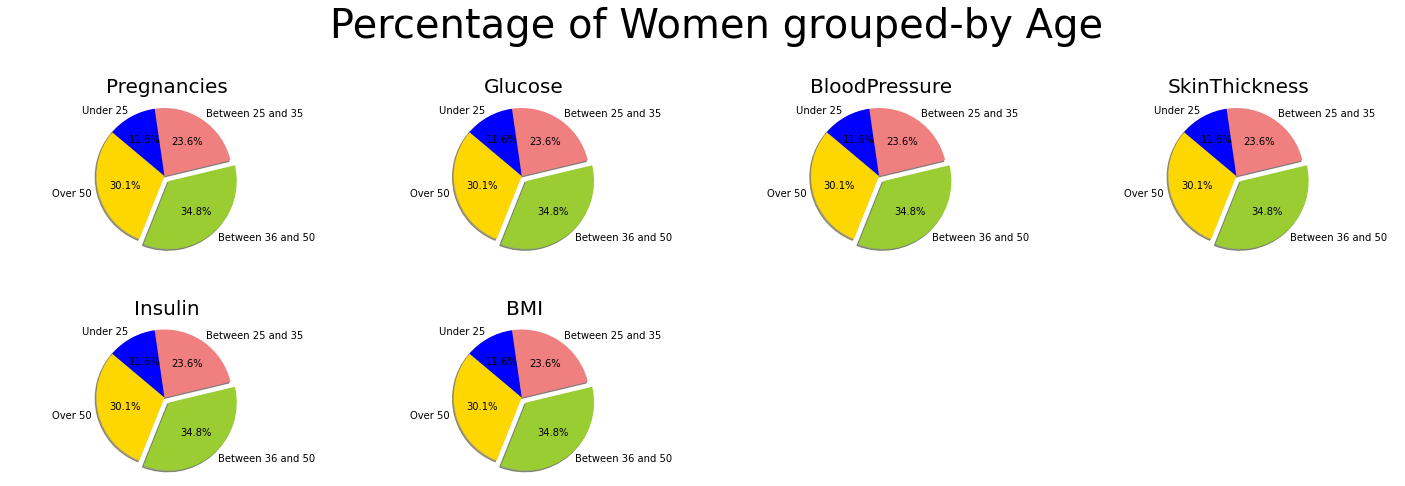

In [ ]:
new_fig = plt.figure(figsize = (20, 10))
new_title = new_fig.suptitle('Percentage of Women grouped-by Age', fontsize = 40, verticalalignment = "center")

colors = ['gold','yellowgreen','lightcoral', 'blue','lightskyblue','green','red']
explode = (0.0, 0.1, 0.0, 0.0)

for i, num in zip(df.columns[:6], range(1, 7)):

  ax1 = new_fig.add_subplot(3, 4, num)
  labels = np.array(groupBy_age_onAnyFeature(window, i).select('Categorized Age').distinct().toPandas()).flatten()
  sizes = np.array(groupBy_age_onAnyFeature(window, i).select('Percent').distinct().toPandas()).flatten()
  plt.title(i, fontsize = 20)
  ax1.pie(sizes, explode = explode, labels = labels, colors = colors, autopct = '%1.1f%%', shadow = True, startangle = 140)
  plt.axis('equal')

plt.tight_layout()
new_title.set_y(0.95)
new_fig.subplots_adjust(top = 0.85, hspace = 0.4)
plt.show()

# Linear Relation - Pearson Correlation

Pearson correlation can be used to weigh each feature against each other to find the most important features, later to be used in our ML model.

In [ ]:
print(df.dtypes[0][0] + " " + df.dtypes[0][1])

Pregnancies int


In [ ]:
num_features = [i[0] for i in df.dtypes if i[1] != 'string']
num_features_df = df.select(num_features)
num_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
0,6,148,72,35,0,33.6,0.627
1,1,85,66,29,0,26.6,0.351
2,8,183,64,0,0,23.3,0.672
3,1,89,66,23,94,28.1,0.167
4,0,137,40,35,168,43.1,2.288


In [ ]:
column_names = num_features_df.columns

Using RDD to analyse Big Data faster

In [ ]:
n = spark.sparkContext.parallelize(num_features)

In [ ]:
features = num_features_df.rdd.map(lambda x: x[:])

for i in features.collect():
  print(i)

In [ ]:
from pyspark.mllib.stat import Statistics

corr_mat = Statistics.corr(features, method = 'pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index = column_names
corr_df.columns = column_names
corr_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000
